In [1]:
import pandas as pd
import os
from os import listdir
from pandas import read_csv
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
import scipy.stats as s
from sklearn.metrics import r2_score
import openmatrix as omx
import math

warnings.filterwarnings("ignore")

work_dir = '/Users/xiaodanxu/Documents/SynthFirm.nosync'
os.chdir(work_dir)
meter_to_mile = 0.00062137
min_to_hour = 1/60
sec_to_hour = 1/3600

In [2]:
# load new skims
region = 'SFBay_calibrated'
skim_dir = 'RawData/BEAM_skims/' + region
skim_files = listdir(skim_dir)
#print(skim_files)

for file in skim_files:
    print(file)
    if file == '.DS_Store':
        continue
    beam_skim = omx.open_file(os.path.join(skim_dir, file), 'a')
    break
# print(beam_skim)

.DS_Store
skims.omx


In [3]:
combined_dist = None
combined_time = None
list_of_period = ['EA', 'AM', 'MD', 'PM', 'EV']

for tp in list_of_period:
    print(tp)
    dist_attr = 'SOV_DIST__' + tp
    dist_skim = beam_skim[dist_attr]
    dist_skim_df = pd.DataFrame(dist_skim)
    dist_skim_df = pd.melt(dist_skim_df)
    dist_skim_df = dist_skim_df.reset_index()  
    dist_skim_df.columns = ['origin', 'destination', 'dist_mile']
    dist_skim_df.loc[:, 'time_period'] = tp
    combined_dist = pd.concat([combined_dist, dist_skim_df])

    time_attr = 'SOV_TIME__' + tp
    time_skim = beam_skim[time_attr]
    time_skim_df = pd.DataFrame(time_skim)
    time_skim_df = pd.melt(time_skim_df)
    time_skim_df = time_skim_df.reset_index()  
    time_skim_df.columns = ['origin', 'destination', 'ttime_min']
    time_skim_df.loc[:, 'time_period'] = tp
    combined_time = pd.concat([combined_time, time_skim_df])
    # break
print(dist_skim_df['destination'].unique()[0:5])
combined_time.head(5)

EA
AM
MD
PM
EV
[0 1 2 3 4]


,origin,destination,ttime_min,time_period
0,0,0,0.595833,EA
1,1,0,1.933333,EA
2,2,0,5.100000,EA
3,3,0,0.639424,EA
4,4,0,3.833333,EA


In [4]:
# combine time and distance
combined_skim = pd.merge(combined_dist, combined_time,
                         on = ['origin', 'destination', 'time_period'],
                        how = 'left')
print('total missing value is ' + str(combined_skim.isnull().sum())) 
combined_skim.loc[:, 'avg_speed_mph'] = \
combined_skim.loc[:, 'dist_mile'] * 60 / combined_skim.loc[:, 'ttime_min']
combined_skim.head(5)

total missing value is origin         0
destination    0
dist_mile      0
time_period    0
ttime_min      0
dtype: int64


,origin,destination,dist_mile,time_period,ttime_min,avg_speed_mph
0,0,0,1.359413,EA,0.595833,136.891891
1,1,0,1.931047,EA,1.933333,59.929058
2,2,0,4.646851,EA,5.100000,54.668831
3,3,0,0.571454,EA,0.639424,53.622086
4,4,0,3.484037,EA,3.833333,54.532757


88090


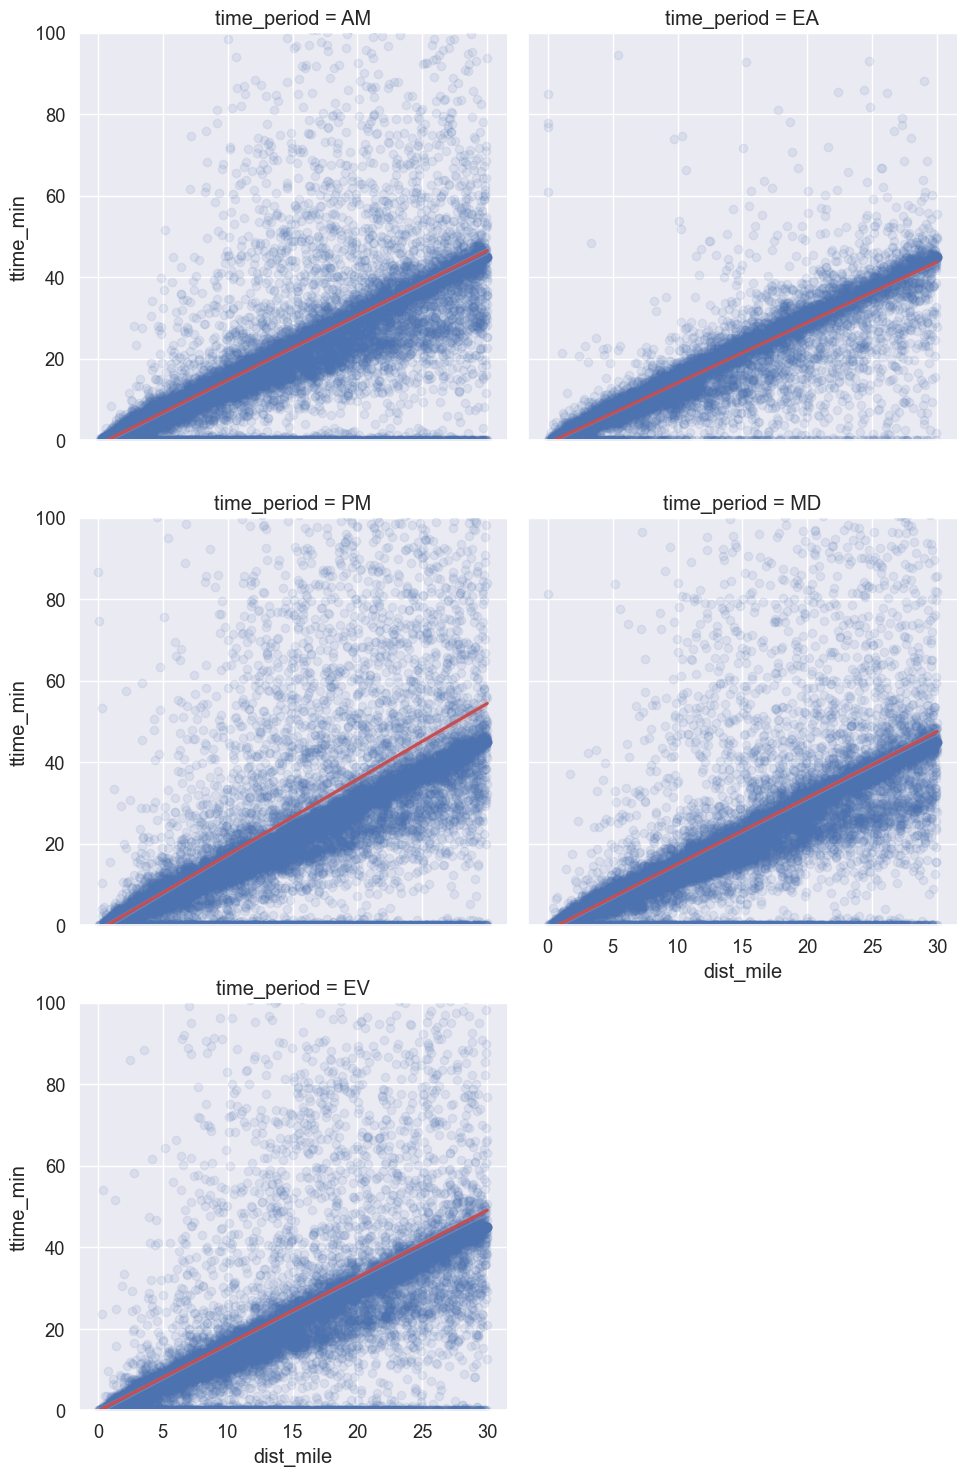

<Axes: >

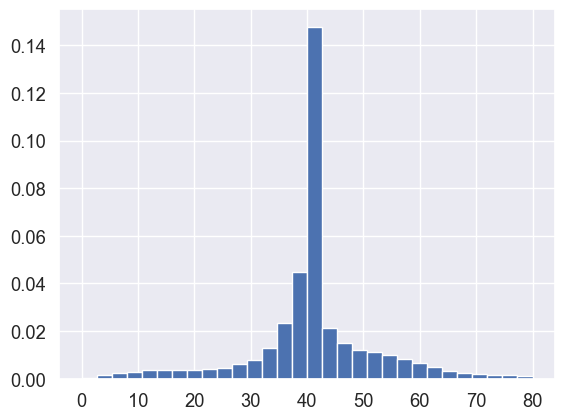

In [12]:
combined_skim_sample = combined_skim.sample(200000)
combined_skim_sample = \
combined_skim_sample.loc[combined_skim_sample['dist_mile'] <= 30]
print(len(combined_skim_sample))
sns.set(font_scale=1.2)  # larger font
sns.lmplot(data = combined_skim_sample, x="dist_mile", y="ttime_min", 
            col = 'time_period', col_wrap = 2, ci = 95,
           scatter_kws = {'alpha':0.1},
          line_kws = {'color': 'r'})
plt.ylim([0, 100])
plt.show()

combined_skim_sample = \
combined_skim_sample.loc[combined_skim_sample['avg_speed_mph']<= 80]
combined_skim_sample['avg_speed_mph'].hist(bins = 30, density = True)


In [24]:
combined_skim.loc[:, 'dist_bin'] = combined_skim.loc[:, 'dist_mile'].astype(int)

combined_skim.loc[combined_skim['dist_bin']>100, 'dist_bin'] = 100

combined_skim_agg = \
combined_skim.groupby(['dist_bin', 'time_period'])[['ttime_min']].mean()
combined_skim_agg = combined_skim_agg.reset_index()
combined_skim_agg.head(5)


,dist_bin,time_period,ttime_min
0,0,AM,1.804450
1,0,EA,5.086941
2,0,EV,3.500495
3,0,MD,2.911406
4,0,PM,2.544106


(0.0, 60.0)

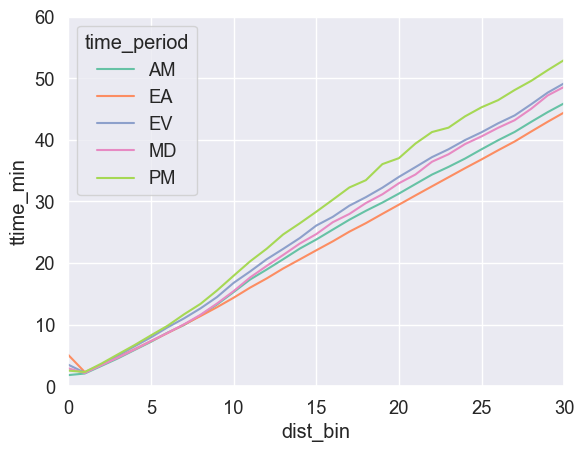

In [27]:
sns.lineplot(data=combined_skim_agg, x="dist_bin", y="ttime_min", 
             hue="time_period", palette = 'Set2')
plt.xlim([0, 30])
plt.ylim([0, 60])


In [20]:
# load old BEAM skim 
region = 'SFBay'
skim_dir = 'RawData/BEAM_skims/' + region
skim_files = listdir(skim_dir)

beam_skim_out = None
var_to_keep = ['timePeriod', 'pathType',
               'origin', 'destination', 
               'TIME_minutes', 'DIST_meters']

var_to_keep_aus = ['hour', 'mode', 
                   'origTaz', 'destTaz', 
                   'travelTimeInS',
                   'distanceInM', 'observations']
for file in skim_files:
    print(file)
    if file == '.DS_Store':
        continue
    beam_skim = read_csv(os.path.join(skim_dir, file))
    print(len(beam_skim))
    if region == 'SFBay':
        beam_skim = beam_skim.loc[beam_skim['pathType'] == 'SOV']
        beam_skim = beam_skim.loc[beam_skim['timePeriod'] == 'PM']
        beam_skim = beam_skim[var_to_keep]
    elif region == 'Austin' or region == 'SFBay_sample':
        beam_skim = beam_skim.loc[beam_skim['mode'] == 'CAR']
#         beam_skim = beam_skim.loc[beam_skim['hour'] == 7]
        beam_skim = beam_skim[var_to_keep_aus]
    print(len(beam_skim))
    beam_skim_out = pd.concat([beam_skim_out, beam_skim])
#     break
# print(beam_skim.columns)
beam_skim_out.head(5)

result_skims-sfbay-00.csv.gz
17546382
1412332
result_skims-sfbay-12.csv.gz
5020667
467581
result_skims-sfbay-24.csv.gz
3298005
464772
result_skims-sfbay-10.csv.gz
4993581
467628
result_skims-sfbay-02.csv.gz
16751980
1411267
result_skims-sfbay-22.csv.gz
9968253
1411161
result_skims-sfbay-06.csv.gz
14008605
1405683
result_skims-sfbay-18.csv.gz
4948837
468964
result_skims-sfbay-14.csv.gz
5165354
469102
result_skims-sfbay-20.csv.gz
4632548
458059
result_skims-sfbay-08.csv.gz
17262041
1402799
result_skims-sfbay-16.csv.gz
4470607
466481
result_skims-sfbay-04.csv.gz
13023097
1411869
result_skims-sfbay-25.csv.gz
2622043
422396
result_skims-sfbay-01.csv.gz
17291227
1412268
result_skims-sfbay-13.csv.gz
5099929
468641
result_skims-sfbay-11.csv.gz
5070294
467630
result_skims-sfbay-03.csv.gz
13539856
1410745
result_skims-sfbay-19.csv.gz
4717688
465915
result_skims-sfbay-07.csv.gz
18073749
1412414
result_skims-sfbay-15.csv.gz
5147682
468432
result_skims-sfbay-23.csv.gz
3440295
460775
result_skims-sf

,timePeriod,pathType,origin,destination,TIME_minutes,DIST_meters
3,PM,SOV,60014001001,60014001001,0.266667,168.736
13,PM,SOV,60014001001,60014002001,4.750000,3080.536
29,PM,SOV,60014001001,60014002002,5.450000,3522.123
45,PM,SOV,60014001001,60014003001,5.708333,4224.126
61,PM,SOV,60014001001,60014003002,6.370000,5215.535


In [4]:
cbg_to_taz_file = 'cbg_taz_mapping.csv'
cbg_to_taz = read_csv('RawData/BEAM_skims/' + cbg_to_taz_file)

cbg_to_taz['taz1454'] = cbg_to_taz['taz1454'].astype(int)
cbg_to_taz.head(5)

,GEOID,taz1454
0,60411242004,1446
1,60750108001,35
2,60014227001,1007
3,60750611002,25
4,60855094013,365


In [5]:
beam_skim_sample = beam_skim.head(1000)
beam_skim_sample.to_csv('RawData/beam_skim_sample_sf.csv')
# print(beam_skim.pathType.unique())
# print(beam_skim.timePeriod.unique())

In [5]:
def weighted_avg_and_std(df, values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(df[values], weights=df[weights])
    # Fast and numerically precise:
    variance = np.average((df[values]-average)**2, weights=df[weights])
    return (average, math.sqrt(variance))

In [22]:
if region == 'SFBay':
    beam_skim_out.loc[:, 'beam_dist_mile'] = beam_skim_out.loc[:, 'DIST_meters'] * meter_to_mile
    beam_skim_out.loc[:, 'beam_time_hour'] = beam_skim_out.loc[:, 'TIME_minutes'] * min_to_hour
elif region == 'Austin' or region == 'SFBay_sample':
    beam_skim_out = beam_skim_out.loc[beam_skim_out['travelTimeInS'] > 0]
    beam_skim_out.loc[:, 'beam_dist_mile'] = beam_skim_out.loc[:, 'distanceInM'] * meter_to_mile
    beam_skim_out.loc[:, 'beam_time_hour'] = beam_skim_out.loc[:, 'travelTimeInS'] * sec_to_hour
    beam_skim_out.loc[:, 'beam_speed_mph'] = beam_skim_out.loc[:, 'beam_dist_mile'] / \
    beam_skim_out.loc[:, 'beam_time_hour']
    beam_skim_out.loc[:, 'beam_weight'] = beam_skim_out.loc[:, 'beam_dist_mile'] / \
    beam_skim_out.loc[:, 'observations']
    print(len(beam_skim_out))

print(beam_skim_out['beam_time_hour'].mean())
print(beam_skim_out['beam_dist_mile'].mean())

beam_skim_out = beam_skim_out.dropna()
# print(weighted_avg_and_std(beam_skim_out, 'beam_speed_mph','beam_weight'))
beam_skim_out.head(5)

0.6743790379635428
41.4863659725056


,timePeriod,pathType,origin,destination,TIME_minutes,DIST_meters,beam_dist_mile,beam_time_hour
3,PM,SOV,60014001001,60014001001,0.266667,168.736,0.104847,0.004444
13,PM,SOV,60014001001,60014002001,4.750000,3080.536,1.914153,0.079167
29,PM,SOV,60014001001,60014002002,5.450000,3522.123,2.188542,0.090833
45,PM,SOV,60014001001,60014003001,5.708333,4224.126,2.624745,0.095139
61,PM,SOV,60014001001,60014003002,6.370000,5215.535,3.240777,0.106167


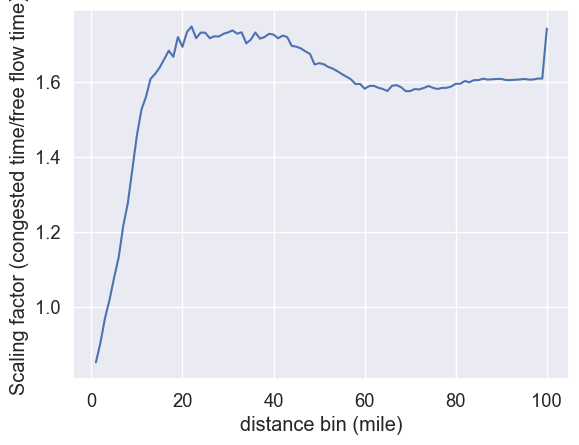

In [35]:
# calculate ttime adjustment factor
beam_skim_out.loc[:, 'dist_bin'] = \
beam_skim_out.loc[:, 'beam_dist_mile'].astype(int)
beam_skim_out.loc[beam_skim_out['dist_bin'] >= 100, 'dist_bin'] = 100
beam_skim_old_agg = beam_skim_out.groupby(['dist_bin'])[['TIME_minutes']].mean()
beam_skim_old_agg = beam_skim_old_agg.reset_index()

# beam_skim_old_agg.head(5)

beam_skim_new_agg = combined_skim_agg.loc[combined_skim_agg['time_period'] == 'PM']
beam_skim_compared = pd.merge(beam_skim_old_agg, beam_skim_new_agg,
                             on = 'dist_bin', how = 'left')

beam_skim_compared.loc[:, 'scaling_factor'] = \
beam_skim_compared.loc[:, 'ttime_min'] / beam_skim_compared.loc[:, 'TIME_minutes']
beam_skim_compared = beam_skim_compared.loc[beam_skim_compared['dist_bin'] >= 1]
# drop 0 distance
beam_skim_compared.head(5)
sns.lineplot(beam_skim_compared, x = 'dist_bin', y = 'scaling_factor')
plt.xlabel('distance bin (mile)')
plt.ylabel('Scaling factor (congested time/free flow time)')
plt.show()

# beam_skim_compared[['dist_bin', 'TIME_minutes', 'ttime_min']].plot( x = 'dist_bin')
# plt.xlabel('distance bin (mile)')
# plt.ylabel('Travel time (min)')
# plt.legend(['freeflow skim', 'congested skim'])
# plt.show()

In [38]:
beam_skim_compared.columns
beam_skim_compared.columns = ['distance_bin_mile', 'freeflow_ttime_min',
                             'time_period', 'congested_ttime_min', 'scaling_factor']
beam_skim_compared.to_csv('RawData/BEAM_skims/travel_time_scaling_factor.csv',
                         index = False)

126.88213843799998
4.916238904274678


<Axes: xlabel='beam_speed_mph', ylabel='Density'>

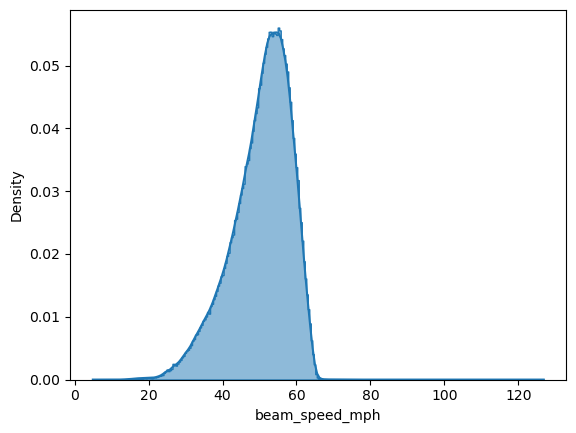

In [11]:
print(beam_skim_out['beam_speed_mph'].max())
print(beam_skim_out['beam_speed_mph'].min())
sns.histplot(data=beam_skim_out, x="beam_speed_mph", 
             weights = 'beam_weight', bins = 300, stat = 'density', 
             element = 'step', kde=True)

In [17]:
beam_skim_out.travelTimeInS.min()

0.0

In [12]:
# load INRIX skim data
inrix_dir = 'PrivateData/INRIX'
inrix_file = 'CA_travel_time.csv'
inrix_skim = read_csv(os.path.join(inrix_dir, inrix_file))
inrix_skim = inrix_skim.loc[inrix_skim['vehicle_weight_class'] == 1]
inrix_skim.head(5)

,start_cbg,end_cbg,start_hour,vehicle_weight_class,trip_distance_mile,travel_time_h,trip_count,trip_avg_speed_mph
0,60014001001,60014001001,4,1,10.548005,0.373056,3,28.274623
1,60014001001,60014001001,5,1,9.840179,0.415040,7,23.709008
2,60014001001,60014001001,6,1,0.993910,0.164778,5,6.031818
3,60014001001,60014001001,7,1,4.618263,0.299974,53,15.395556
5,60014001001,60014001001,8,1,3.939518,0.298660,74,13.190650


<Axes: xlabel='start_hour'>

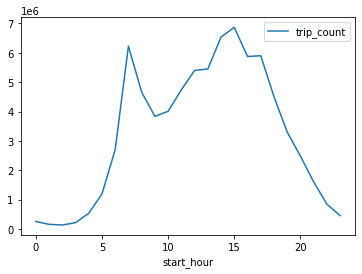

In [16]:
hourly_trip_count = inrix_skim.groupby('start_hour')[['trip_count']].sum()
hourly_trip_count.plot()

In [13]:
if region == 'SFBay_sample':
    cbg_to_taz.columns = ['start_cbg', 'origTaz']
    inrix_skim = pd.merge(inrix_skim, cbg_to_taz,
                         on = 'start_cbg', how = 'left')
    cbg_to_taz.columns = ['end_cbg', 'destTaz']
    inrix_skim = pd.merge(inrix_skim, cbg_to_taz,
                         on = 'end_cbg', how = 'left')
    inrix_skim.loc[:, 'inrix_dist_mile'] = \
    inrix_skim.loc[:, 'trip_distance_mile'] * \
    inrix_skim.loc[:, 'trip_count'] 
    inrix_skim.loc[:, 'inrix_time_hour'] = \
    inrix_skim.loc[:, 'travel_time_h'] * \
    inrix_skim.loc[:, 'trip_count'] 
    inrix_skim.loc[:, 'inrix_weight'] = \
    inrix_skim.loc[:, 'inrix_dist_mile'] * \
    inrix_skim.loc[:, 'trip_count'] 
    inrix_skim_by_taz = \
    inrix_skim.groupby(['origTaz','destTaz', 'start_hour'])[['inrix_dist_mile', 'inrix_time_hour', 'trip_count', 'inrix_weight']].sum()
    inrix_skim_by_taz = inrix_skim_by_taz.reset_index()
    inrix_skim_by_taz.loc[:, 'inrix_dist_mile'] = \
    inrix_skim_by_taz.loc[:, 'inrix_dist_mile'] / \
    inrix_skim_by_taz.loc[:, 'trip_count'] 
    inrix_skim_by_taz.loc[:, 'inrix_time_hour'] = \
    inrix_skim_by_taz.loc[:, 'inrix_time_hour'] / \
    inrix_skim_by_taz.loc[:, 'trip_count'] 
inrix_skim_by_taz.head(5)

,origTaz,destTaz,start_hour,inrix_dist_mile,inrix_time_hour,trip_count,inrix_weight
0,2.0,2.0,0,11.814841,1.185556,4,189.037456
1,2.0,2.0,1,3.451250,0.343056,1,3.451250
2,2.0,2.0,2,3.902351,0.289653,4,62.437611
3,2.0,2.0,3,6.885306,0.731250,2,27.541223
4,2.0,2.0,4,2.356582,0.296833,5,58.914538


In [14]:
# apply this to new SF results
if region == 'SFBay_sample':
    inrix_skim_by_taz.loc[:, 'inrix_speed_mph'] = \
    inrix_skim_by_taz.loc[:, 'inrix_dist_mile'] / \
    inrix_skim_by_taz.loc[:, 'inrix_time_hour']
    beam_skim_out = beam_skim_out.rename(columns = {'origTaz':'origin',
                                          'destTaz': 'destination'})
    inrix_skim_by_taz = inrix_skim_by_taz.rename(columns = {'origTaz':'origin',
                                              'destTaz': 'destination',
                                             'trip_count': 'sample_size',
                                            'start_hour': 'hour'})
    beam_skim_compare = pd.merge(beam_skim_out,
                                 inrix_skim_by_taz,
                                 on = ['origin', 'destination', 'hour'],
                                 how = 'inner')
print(len(beam_skim_compare))
print(beam_skim_compare['sample_size'].sum())
print(beam_skim_compare['observations'].sum())
beam_skim_compare.head(5)

426508
5295101
806876


,hour,mode,origin,destination,travelTimeInS,distanceInM,observations,beam_dist_mile,beam_time_hour,beam_speed_mph,beam_weight,inrix_dist_mile,inrix_time_hour,sample_size,inrix_weight,inrix_speed_mph
0,15,CAR,948,874,298.0,6877.0140,1,4.273170,0.082778,51.622190,4.273170,6.415079,0.494722,2,12.830157,12.967031
1,17,CAR,1136,1246,1411.0,30009.4550,1,18.646975,0.391944,47.575556,18.646975,18.996870,0.453333,1,18.996870,41.904860
2,17,CAR,1068,1072,253.5,4846.1565,2,3.011256,0.070417,42.763403,1.505628,2.419654,0.185662,13,97.735311,13.032546
3,19,CAR,71,104,452.0,6896.0900,1,4.285023,0.125556,34.128505,4.285023,1.883509,0.299444,1,1.883509,6.290013
4,14,CAR,427,674,900.0,24547.2520,1,15.252926,0.250000,61.011704,15.252926,16.307931,0.566556,5,180.050246,28.784347


In [19]:
# produce summary statistics
dist_r2 = r2_score(beam_skim_compare['inrix_dist_mile'], 
                  beam_skim_compare['beam_dist_mile'])
print('r2 score for routed distance ' + str(np.round(dist_r2, 2)))

time_r2 = r2_score(beam_skim_compare['inrix_time_hour'], 
                  beam_skim_compare['beam_time_hour'])
print('r2 score for routed travel time ' + str(np.round(time_r2, 2)))

print(weighted_avg_and_std(beam_skim_compare, 'inrix_dist_mile','sample_size'))
print(weighted_avg_and_std(beam_skim_compare, 'beam_dist_mile','observations'))

print(weighted_avg_and_std(beam_skim_compare, 'inrix_time_hour','sample_size'))
print(weighted_avg_and_std(beam_skim_compare, 'beam_time_hour','observations'))

print(weighted_avg_and_std(beam_skim_compare, 'inrix_speed_mph','inrix_weight'))
print(weighted_avg_and_std(beam_skim_compare, 'beam_speed_mph','beam_weight'))
#       np.round(beam_skim_compare['beam_dist_mile'].mean(), 2),
#      np.round(beam_skim_compare['inrix_time_hour'].mean(), 2),
#      np.round(beam_skim_compare['beam_time_hour'].mean(), 2))

# print(np.round(beam_skim_compare['inrix_dist_mile'].std(), 2),
#       np.round(beam_skim_compare['beam_dist_mile'].std(), 2),
#      np.round(beam_skim_compare['inrix_time_hour'].std(), 2),
#      np.round(beam_skim_compare['beam_time_hour'].std(), 2))

r2 score for routed distance 0.62
r2 score for routed travel time -0.42
(3.77702897073142, 3.3825666360615303)
(4.665889363382093, 4.658025029956564)
(0.22529556859360292, 0.11975434097316404)
(0.10372889046423771, 0.09328514767452196)
(15.730845261356887, 4.860766498402809)
(48.29749480108318, 8.475993147418736)


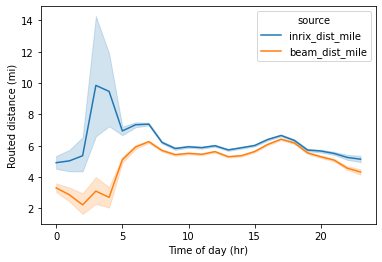

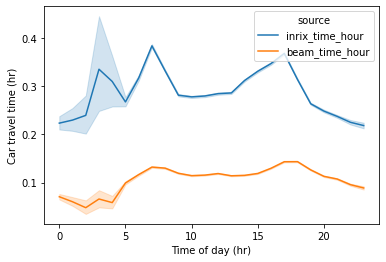

In [26]:
# validation by TOD
travel_dist_compare = pd.melt(beam_skim_compare, 
                              id_vars=['origin', 'destination', 'hour'], 
                              value_vars=['inrix_dist_mile', 'beam_dist_mile'],
                             var_name='source', value_name='distance')
# travel_dist_compare.head(5)
# sns.lineplot(data = travel_dist_compare, 
#              x="hour", y="distance", hue="source")
# plt.show()

travel_time_compare = pd.melt(beam_skim_compare, 
                              id_vars=['origin', 'destination', 'hour'], 
                              value_vars=['inrix_time_hour', 'beam_time_hour'],
                             var_name='source', value_name='time')
# travel_dist_compare.head(5)
# dist plot
sns.lineplot(data = travel_dist_compare, 
             x="hour", y="distance", hue="source")
plt.xlabel('Time of day (hr)')
plt.ylabel('Routed distance (mi)')
plt.savefig('plots_SF/SF_skim_dist_by_TOD.png', dpi = 300)
plt.show()

# time plot
sns.lineplot(data = travel_time_compare, 
             x="hour", y="time", hue="source")
plt.xlabel('Time of day (hr)')
plt.ylabel('Car travel time (hr)')
plt.savefig('plots_SF/SF_skim_time_by_TOD.png', dpi = 300)
plt.show()

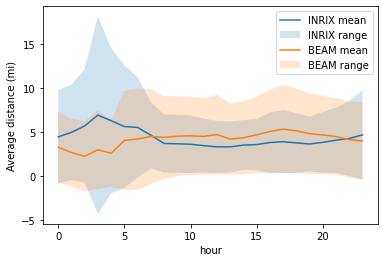

In [62]:
# plot weighted distance
hour_dist_inrix = \
beam_skim_compare.groupby(['hour']).apply(lambda x: pd.Series(weighted_avg_and_std(x, 'inrix_dist_mile', 'sample_size')))

hour_dist_inrix.columns = ['avg distance', 'std error']
hour_dist_inrix = hour_dist_inrix.reset_index()
hour_dist_inrix.loc[:, 'source'] = 'INRIX'
hour_dist_inrix.loc[:, 'upper'] = hour_dist_inrix.loc[:, 'avg distance'] + \
hour_dist_inrix.loc[:, 'std error']
hour_dist_inrix.loc[:, 'lower'] = hour_dist_inrix.loc[:, 'avg distance'] - \
hour_dist_inrix.loc[:, 'std error']
hour_dist_inrix.head(5)

hour_dist_beam = \
beam_skim_compare.groupby(['hour']).apply(lambda x: pd.Series(weighted_avg_and_std(x, 'beam_dist_mile', 'observations')))

hour_dist_beam.columns = ['avg distance', 'std error']
hour_dist_beam = hour_dist_beam.reset_index()
hour_dist_beam.loc[:, 'source'] = 'BEAM'
hour_dist_beam.loc[:, 'upper'] = hour_dist_beam.loc[:, 'avg distance'] + \
hour_dist_beam.loc[:, 'std error']
hour_dist_beam.loc[:, 'lower'] = hour_dist_beam.loc[:, 'avg distance'] - \
hour_dist_beam.loc[:, 'std error']
hour_dist_beam.head(5)

# generate plot

ax = sns.lineplot(data = hour_dist_inrix, x = 'hour', y="avg distance", ci=None)
ax.fill_between(hour_dist_inrix.hour, hour_dist_inrix.lower, hour_dist_inrix.upper, alpha=0.2)

sns.lineplot(data = hour_dist_beam, x = 'hour', y="avg distance", ci=None, ax = ax)
ax.fill_between(hour_dist_beam.hour, hour_dist_beam.lower, hour_dist_beam.upper, alpha=0.2)

plt.legend(['INRIX mean', 'INRIX range', 'BEAM mean', 'BEAM range'])
plt.ylabel('Average distance (mi)')
plt.savefig('plots_SF/SF_skim_dist_by_TOD_weighted.png', dpi = 300)
plt.show()

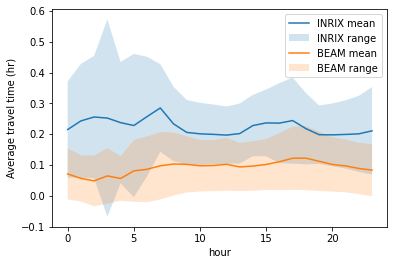

In [63]:
# plot weighted time
hour_time_inrix = \
beam_skim_compare.groupby(['hour']).apply(lambda x: pd.Series(weighted_avg_and_std(x, 'inrix_time_hour', 'sample_size')))

hour_time_inrix.columns = ['avg travel time', 'std error']
hour_time_inrix = hour_time_inrix.reset_index()
hour_time_inrix.loc[:, 'source'] = 'INRIX'
hour_time_inrix.loc[:, 'upper'] = hour_time_inrix.loc[:, 'avg travel time'] + \
hour_time_inrix.loc[:, 'std error']
hour_time_inrix.loc[:, 'lower'] = hour_time_inrix.loc[:, 'avg travel time'] - \
hour_time_inrix.loc[:, 'std error']
hour_time_inrix.head(5)

hour_time_beam = \
beam_skim_compare.groupby(['hour']).apply(lambda x: pd.Series(weighted_avg_and_std(x, 'beam_time_hour', 'observations')))

hour_time_beam.columns = ['avg travel time', 'std error']
hour_time_beam = hour_time_beam.reset_index()
hour_time_beam.loc[:, 'source'] = 'BEAM'
hour_time_beam.loc[:, 'upper'] = hour_time_beam.loc[:, 'avg travel time'] + \
hour_time_beam.loc[:, 'std error']
hour_time_beam.loc[:, 'lower'] = hour_time_beam.loc[:, 'avg travel time'] - \
hour_time_beam.loc[:, 'std error']
hour_time_beam.head(5)

# generate plot

ax = sns.lineplot(data = hour_time_inrix, x = 'hour', y="avg travel time", ci=None)
ax.fill_between(hour_time_inrix.hour, hour_time_inrix.lower, hour_time_inrix.upper, alpha=0.2)

sns.lineplot(data = hour_time_beam, x = 'hour', y="avg travel time", ci=None, ax = ax)
ax.fill_between(hour_time_beam.hour, hour_time_beam.lower, hour_time_beam.upper, alpha=0.2)

plt.legend(['INRIX mean', 'INRIX range', 'BEAM mean', 'BEAM range'])
plt.ylabel('Average travel time (hr)')
plt.savefig('plots_SF/SF_skim_time_by_TOD_weighted.png', dpi = 300)
plt.show()

In [56]:
beam_skim_compare.groupby(['hour']).apply(lambda x: weighted_avg_and_std(x, 'inrix_dist_mile', 'sample_size'))

hour
0       (4.457445918626792, 5.302225057181969)
1       (4.970044932710635, 5.428951929850439)
2      (5.7068375503697695, 6.452051997827735)
3      (6.942096094858466, 11.237229677330925)
4       (6.309460957680331, 8.268268305543046)
5      (5.637467803076038, 6.9744498002002855)
6      (5.536406097564707, 5.7256716555121105)
7        (4.65699275619298, 3.769729057768812)
8      (3.715416676930803, 3.2977468430246404)
9       (3.67837048701256, 3.2998343124075458)
10       (3.625754518582102, 3.27242281069907)
11     (3.466769819672153, 3.0668931719342507)
12     (3.3289841595117333, 2.951329705327543)
13     (3.326347531076025, 2.8981290208297557)
14      (3.5318237559511694, 2.83224475212182)
15     (3.5883305061893975, 2.918341094361562)
16      (3.820463139064155, 3.417719580049251)
17    (3.9185601992988466, 3.5880340335902643)
18     (3.779673731541137, 3.3860944497299283)
19    (3.6518016562399516, 3.1197944610463297)
20     (3.8454384889593394, 3.444795773565022)
21      

In [33]:
# inrix_skim_am = inrix_skim.loc[inrix_skim['start_hour'] == 7]
# inrix_skim_am = inrix_skim_am[['start_cbg', 'end_cbg', 
#                                'trip_distance_mile', 'travel_time_h', 'trip_count']]
# inrix_skim_am.columns = ['origin', 'destination', 
#                          'inrix_dist_mile', 'inrix_time_hour', 'sample_size']
# if region == 'Austin':
#     beam_skim_out = beam_skim_out.rename(columns = {'origTaz':'origin',
#                                           'destTaz': 'destination'})
# beam_skim_compare = pd.merge(beam_skim_out,
#                              inrix_skim_am,
#                              on = ['origin', 'destination'],
#                              how = 'inner')
# print(len(beam_skim_compare))
# beam_skim_compare.head(5)

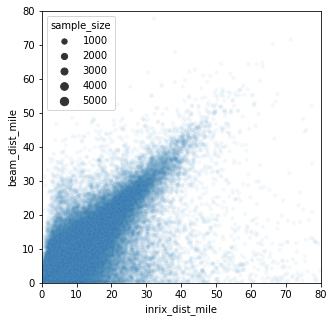

In [32]:

plt.figure(figsize = (5,5))
sns.scatterplot(data=beam_skim_compare, x="inrix_dist_mile", 
                y="beam_dist_mile", alpha = 0.05, 
                size = 'sample_size')
plt.xlim([0,80])
plt.ylim([0,80])
plt.show()

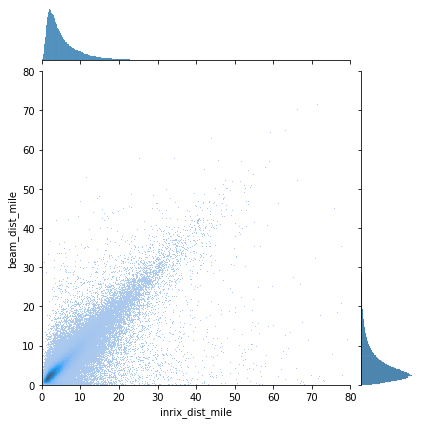

In [28]:
sns.jointplot(data=beam_skim_compare, x="inrix_dist_mile", 
                y="beam_dist_mile", kind="hist")
plt.xlim([0,80])
plt.ylim([0,80])
plt.savefig('plots_SF/SF_travel_dist_skim_validation.png', dpi = 300, 
           bbox_inches = 'tight')
plt.show()

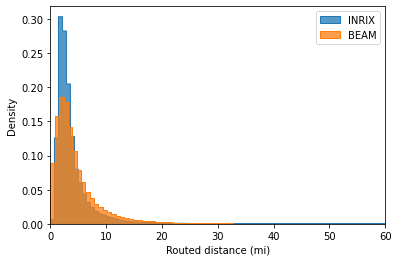

In [45]:
sns.histplot(data=beam_skim_compare, x="inrix_dist_mile", 
             weights = 'sample_size', bins = 300, stat = 'density', 
             element = 'step', kde=False)

sns.histplot(data=beam_skim_compare, x="beam_dist_mile", 
             weights = 'observations', bins = 100, stat = 'density', 
             element = 'step', kde=False)

plt.xlim([0, 60])
plt.xlabel('Routed distance (mi)')
plt.legend(['INRIX', 'BEAM'])
plt.savefig('plots_SF/SF_travel_dist_skim_weighted.png', dpi = 300, 
           bbox_inches = 'tight')

plt.show()

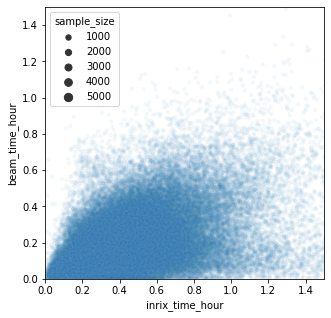

In [31]:
plt.figure(figsize = (5,5))
sns.scatterplot(data=beam_skim_compare, x="inrix_time_hour", 
                y="beam_time_hour", alpha = 0.05, 
                size = 'sample_size')
plt.xlim([0,1.5])
plt.ylim([0,1.5])
plt.show()

In [30]:
print(len(beam_skim_compare.origin.unique()))
print(len(beam_skim_compare.destination.unique()))

1385
1387


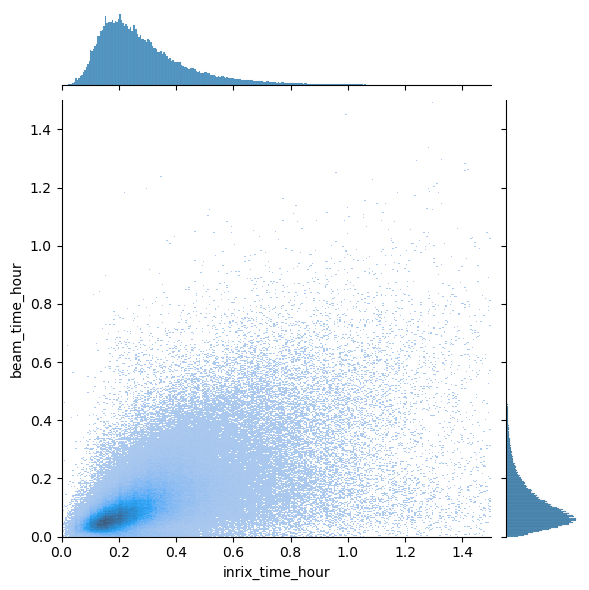

In [15]:
sns.jointplot(data=beam_skim_compare, x="inrix_time_hour", 
                y="beam_time_hour", kind="hist")
plt.xlim([0,1.5])
plt.ylim([0,1.5])
plt.savefig('plots_SF/SF_travel_time_skim_validation.png', dpi = 300, 
           bbox_inches = 'tight')
plt.show()

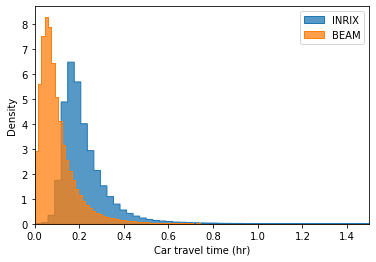

In [43]:
sns.histplot(data=beam_skim_compare, x="inrix_time_hour", 
             weights = 'sample_size', bins = 300, stat = 'density', 
             element = 'step', kde=False)

sns.histplot(data=beam_skim_compare, x="beam_time_hour", 
             weights = 'observations', bins = 100, stat = 'density', 
             element = 'step', kde=False)

plt.xlim([0, 1.5])
plt.xlabel('Car travel time (hr)')
plt.legend(['INRIX', 'BEAM'])
plt.savefig('plots_SF/SF_travel_time_skim_weighted.png', dpi = 300, 
           bbox_inches = 'tight')

plt.show()

In [40]:
#beam_skim_out.to_csv('RawData/travel_skim_beam.csv.zip')
beam_skim_out = read_csv('RawData/travel_skim_beam.csv.zip')

beam_skim_out_sample = beam_skim_out.head(1000)
beam_skim_out_sample.to_csv('RawData/sf_travel_skim_beam_sample.csv', index = False)
beam_skim_out.head(5)

,Unnamed: 0,timePeriod,pathType,origin,destination,TIME_minutes,DIST_meters,beam_dist_mile,beam_time_hour
0,1,AM,SOV,60014001001,60014001001,0.266667,168.736,0.104847,0.004444
1,11,AM,SOV,60014001001,60014002001,4.750000,3080.536,1.914153,0.079167
2,27,AM,SOV,60014001001,60014002002,5.450000,3522.123,2.188542,0.090833
3,43,AM,SOV,60014001001,60014003001,5.708333,4224.126,2.624745,0.095139
4,59,AM,SOV,60014001001,60014003002,6.370000,5215.535,3.240777,0.106167


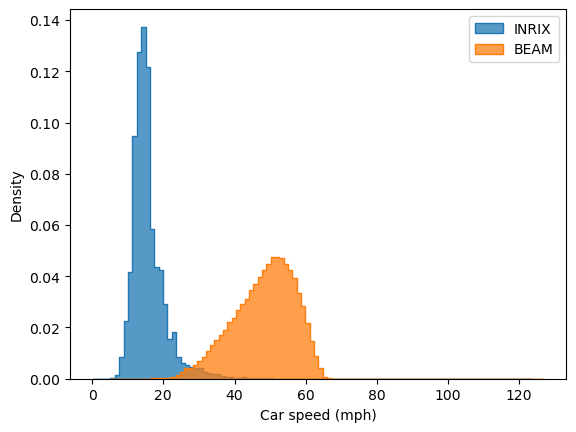

In [18]:
sns.histplot(data=beam_skim_compare, x="inrix_speed_mph", 
             weights = 'inrix_weight', bins = 100, stat = 'density', 
             element = 'step', kde=False)

sns.histplot(data=beam_skim_compare, x="beam_speed_mph", 
             weights = 'beam_weight', bins = 100, stat = 'density', 
             element = 'step', kde=False)

# plt.xlim([0, 1.5])
plt.xlabel('Car speed (mph)')
plt.legend(['INRIX', 'BEAM'])
plt.savefig('plots_SF/SF_travel_speed_skim_weighted.png', dpi = 300, 
           bbox_inches = 'tight')

plt.show()